# MMA Overview

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cooper
import matplotlib.animation as animation
import logging

%matplotlib qt
device = 'cpu'

def setup_logger(logfile):
    # Create logger
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)
    # Create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # Create file handler and set level to debug
    fh = logging.FileHandler(logfile)
    fh.setLevel(logging.DEBUG)
    # Add formatter to ch and fh
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    fh.setFormatter(formatter)
    # Add ch and fh to logger
    logger.addHandler(ch)
    logger.addHandler(fh)
    # Open logfile and reset
    with open(logfile, 'w'): pass
    # Return logger
    return logger

file = "MMA_demos_torch.log"
logger = setup_logger(file)
logger.info("Started\n")

2023-04-27 22:37:53,247 - __main__ - INFO - Started



## Example functions to show convex approximation

In [2]:
class LamModel(nn.Module):
    def __init__(self, lam_fun, x0):
        super().__init__()
        self.x = nn.Parameter(torch.tensor([x0]))
        # self.x = nn.Parameter(torch.tensor([0.0,1.0]))
        # self.x2 = nn.Parameter(torch.tensor([5.0]))
        self.lam_fun = lam_fun

    def forward(self):
        return self.lam_fun(self.x)
        # return self.lam_fun(self.x) + self.x2


quad_fun = lambda x: (x)**2
x_max = 2
x_min = -2

In [60]:


# Define the range of values for x0
x0_values = np.linspace(-2, 2, 6*30)
# append a flipped version of x0_values too
x0_values = np.append(x0_values[:-1], np.flip(x0_values))

# Create a list to hold the frames of the animation
frames = []


fig, ax = plt.subplots()

def animate(x0, ma=1):
    quad_model = LamModel(quad_fun, x0)
    n_params = sum(p.numel() for p in quad_model.parameters() if p.requires_grad)
    output = torch.sum(quad_model.forward())

    # Get the gradient of the output with respect to the parameters of the model
    dfdx = torch.autograd.grad(output, quad_model.parameters(), create_graph=True)

    # Reshape the gradient into a vector
    dfdx = torch.cat([g.contiguous().view(-1) for g in dfdx])

    # Define the MMA parameters
    x_current = quad_model.x.data
    lower = x_current - 0.5/ma*(x_max-x_min)
    upper = x_current + 0.5/ma*(x_max-x_min)

    # Construct the approximate constants
    p = (upper-x_current)**2 * (1.001 * torch.relu(dfdx) + 0.001 * torch.relu(-dfdx) + 1e-5/(x_max-x_min))
    q = (x_current-lower)**2 * (0.001 * torch.relu(dfdx) + 1.001 * torch.relu(-dfdx) + 1e-5/(x_max-x_min))
    r = output - torch.sum( p/(upper-x_current) + q/(x_current-lower) )

    alpha1 = x_min
    alpha2 = lower + 0.1*(x_current-lower)
    alpha3 = x_current - 0.5*(x_max-x_min)
    alphas = [alpha1, alpha2, alpha3]
    alphas = [float(a) for a in alphas]
    alpha = max(alphas)
    beta1 = x_max
    beta2 = upper - 0.1*(upper-x_current)
    beta3 = x_current + 0.5*(x_max-x_min)
    betas = [beta1, beta2, beta3]
    betas = [float(b) for b in betas]
    beta = min(betas)

    # colors for the bounds above, make them similar but slightly different
    colors = ['magenta', 'cyan', 'orange']

    x_t = torch.linspace(alpha, beta, 100)
    f_tilde = p/(upper-x_t) + q/(x_t-lower) + r


    # Plot the function, and the current value of x, and the current value of the function
    x = np.linspace(x_min, x_max, 100)
    yl = [-0.5, 5]

    ax.clear()
    ax.plot(x, quad_fun(x))
    ax.plot(quad_model.x.detach().numpy(), quad_fun(quad_model.x.detach().numpy()), 'o')
    ax.plot(x_t, f_tilde.detach().numpy())
    # Plot the MMA parameters as vertical dotted lines
    for (i, (alpha, beta)) in enumerate(zip(alphas,betas)):
        ax.plot([alpha, alpha], yl, '--', color = colors[i])
        ax.plot([beta, beta], yl, '--', color = colors[i])
    ax.set_ylim(yl)
    ax.set_xlim([x_min*1.1, x_max*1.1])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.set_title(rf'$x^{{(0)}}$ = {x0:.2f}')
    # Convert the plot to an image and add it to the frames list
    fig.canvas.draw

ma = 2
anim_fun = lambda x0: animate(x0, ma=ma)
anim = animation.FuncAnimation(fig, anim_fun, frames=x0_values, interval=6000/len(x0_values))
anim.save(f'quad_fun_ma{ma}.gif', writer='imagemagick')

# close figure
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


Traceback (most recent call last):
  File "c:\Users\grant\anaconda3\envs\torch_pde\lib\site-packages\matplotlib\cbook\__init__.py", line 287, in process
    func(*args, **kwargs)
  File "c:\Users\grant\anaconda3\envs\torch_pde\lib\site-packages\matplotlib\animation.py", line 911, in _start
    self.event_source.add_callback(self._step)
AttributeError: 'NoneType' object has no attribute 'add_callback'


## Show how the moving asymptotes work for the example

In [101]:
x0 = -1.9
xk = [x0]
x0 = xk[0]
print(xk)
upper_hist = []
lower_hist = []

def mma_update(frame_ct):
    # frame_ct is a weird variable here. It is not the iteration number of MMA. I use frame_ct for plotting as a gif, so there are two frames for each MMA iteration.

    # x0 is really x^(k)
    x0 = xk[-1]
    k = frame_ct//2
    quad_model = LamModel(quad_fun, x0)
    n_params = sum(p.numel() for p in quad_model.parameters() if p.requires_grad)
    output = torch.sum(quad_model.forward())

    # Get the gradient of the output with respect to the parameters of the model, using AD
    # There are other ways to do this, such as initializing the gradient, looping through the parameters(), and grabbing .grad from each parameter.
    dfdx = torch.autograd.grad(output, quad_model.parameters(), create_graph=True)

    # Reshape the gradient into a vector
    dfdx = torch.cat([g.contiguous().view(-1) for g in dfdx])

    x_current = quad_model.x.data
    if k<2:
        lower = x_current - 0.5*(x_max-x_min)
        upper = x_current + 0.5*(x_max-x_min)
        gamma = np.nan
    else:
        # Update the bounds based on if the last two steps were in the same direction
        deltax_1 = xk[-1] - xk[-2]
        deltax_2 = xk[-2] - xk[-3]
        if deltax_1*deltax_2 < 0:
            gamma = 0.7
        elif deltax_1*deltax_2 > 0:
            gamma = 1.2
        else:
            gamma = 1
        lower = x_current - gamma*(xk[-1] - lower_hist[-1])
        upper = x_current + gamma*(upper_hist[-1] - xk[-1])
    if frame_ct%2==1:
        lower_hist.append(lower)
        upper_hist.append(upper)

    # Construct the approximate constants
    p = (upper-x_current)**2 * (1.001 * torch.relu(dfdx) + 0.001 * torch.relu(-dfdx) + 1e-5/(x_max-x_min))
    q = (x_current-lower)**2 * (0.001 * torch.relu(dfdx) + 1.001 * torch.relu(-dfdx) + 1e-5/(x_max-x_min))
    r = output - torch.sum( p/(upper-x_current) + q/(x_current-lower) )

    alpha1 = x_min
    alpha2 = lower + 0.1*(x_current-lower)
    alpha3 = x_current - 0.5*(x_max-x_min)
    alphas = [alpha1, alpha2, alpha3]
    alphas = [float(a) for a in alphas]
    alpha = max(alphas)
    beta1 = x_max
    beta2 = upper - 0.1*(upper-x_current)
    beta3 = x_current + 0.5*(x_max-x_min)
    betas = [beta1, beta2, beta3]
    betas = [float(b) for b in betas]
    beta = min(betas)

    # colors for the bounds above, make them similar but slightly different
    colors = ['magenta', 'cyan', 'orange']

    x_t = torch.linspace(alpha, beta, 100000)
    f_tilde = p/(upper-x_t) + q/(x_t-lower) + r

    min_ind = torch.argmin(f_tilde)
    min_x = x_t[min_ind]
    min_f = f_tilde[min_ind].detach()
    if frame_ct%2==1:
        xk.append(min_x.item())

    # Plot the function, and the current value of x, and the current value of the function
    x = np.linspace(x_min, x_max, 100)
    yl = [-0.5, 4.2]

    ax.clear()
    ax.plot(x, quad_fun(x))
    ax.plot(quad_model.x.detach().numpy(), quad_fun(quad_model.x.detach().numpy()), 'o')
    ax.plot(x_t, f_tilde.detach().numpy())
    # Plot the MMA parameters as vertical dotted lines
    # Plot only the 2nd beta and 2nd alpha.
    i = 1
    alpha = alphas[i]
    beta = betas[i]
    ax.plot([alpha, alpha], yl, '--', color = colors[i])
    ax.plot([beta, beta], yl, '--', color = colors[i])
    # Plot the minimum of the MMA approximation, as an empty square
    ax.set_ylim(yl)
    ax.set_xlim([x_min*1.1, x_max*1.1])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.set_title(rf'$\gamma^{{({k})}}$ = {gamma:.1f}, $x^{{({k})}}$ = {x0:.2f}, Error = {np.abs(min_f):.1e}')

    if frame_ct%2==1:
        ax.plot(min_x, min_f, 's', color='red', fillstyle='none')

time_per_frame = 5
frames = range(201)
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, mma_update, frames=frames, interval=time_per_frame, repeat=False)
# anim.save('mma_steps.gif', writer='imagemagick')
# close figure
# plt.close()

[-1.9]


In [102]:
xk = np.array(xk)
fk = quad_fun(xk)
ul_hist = np.array(upper_hist)
ll_hist = np.array(lower_hist)
u_m_l_hist = ul_hist - ll_hist

# Set up figure for two y axes. First is for fk, second for u_m_l_hist
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.semilogy(fk, 'b-')
ax2.semilogy(u_m_l_hist, 'r-')
# Plot a line with slope 0.7 on log-linear scale, align it with the first point
# Do the same for a line with slope 1.2, but hard code where to put it.
o_x = np.arange(12)
o_07 = 0.7**o_x
o_x12 = np.arange(11, 24)
o_o12 = 1.2**(o_x12-11)
ind_max = u_m_l_hist.argmax()
o_07 = o_07 * u_m_l_hist[ind_max].item() / o_07[ind_max]
o_o12 = o_o12 * o_07[-1] / o_o12[0]


ax2.semilogy(o_x, o_07, 'r--')
ax2.semilogy(o_x12, o_o12, 'r:')
ax1.set_xlabel('Iteration: $k$')
ax1.set_ylabel('Error: $| f(x^{(k)}) - f^* |$', color='b')
ax2.set_ylabel('Asymptote distance: $u - l$', color='r')
ax1.legend(['$| f(x^{(k)}) - f^* |$'], loc='upper left')
ax2.legend(['$u - l$', '$\mathcal{O} (0.7^k)$', '$\mathcal{O} (1.2^k)$'], loc='upper right')
plt.title('MMA Performance on $(P^{ex})$')
# only major grid lines, slightly blue
ax1.grid(which='major', color='#CCCCFF')
# Save as svg
if len(xk) > 60:
    plt.savefig('mma_steps_extended.svg')
else:
    plt.savefig('mma_steps.svg')

C:\Users\grant\AppData\Local\Temp\ipykernel_8648\1459807984.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ul_hist = np.array(upper_hist)
C:\Users\grant\AppData\Local\Temp\ipykernel_8648\1459807984.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ul_hist = np.array(upper_hist)
C:\Users\grant\AppData\Local\Temp\ipykernel_8648\1459807984.py:4: FutureWarning: T

## Numerical Experiments

Using an implementation of GCMMA / MMA for numpy / scipy: https://github.com/arjendeetman/GCMMA-MMA-Python,
let's look at a few test cases.



In [3]:
# import mma, which is in the same directory, but in its own folder
import sys
import os
sys.path.append('mma/Code/')
from MMA import mmasub,subsolv,kktcheck
%matplotlib inline

# Define a PyTorch model to keep track of our optimization variables
class ModelBar3(nn.Module):
    def __init__(self, x0):
        super().__init__()
        self.x = nn.Parameter(x0)
        self.R = torch.tensor([[1,1/np.sqrt(2),0], [0,1/np.sqrt(2),1]],dtype=torch.float32)
        self.p1 = torch.tensor([1,0],dtype=torch.float32).T
        self.p2 = torch.tensor([1,1],dtype=torch.float32).T
        self.p3 = torch.tensor([0,1],dtype=torch.float32).T
        self.V = 3.0

    def forward(self):
        # This code is from https://github.com/arjendeetman/GCMMA-MMA-Python, just replacing numpy with pytorch
        xval = self.x

        f0val = torch.sum(0*self.x)
        D = torch.diag(xval)
        K = torch.mm(torch.mm(self.R,D),(self.R.T))
        u1 = torch.linalg.solve(K, self.p1)
        u2 = torch.linalg.solve(K, self.p2)
        u3 = torch.linalg.solve(K, self.p3)
        compl1 = torch.dot(self.p1.T, u1)
        compl2 = torch.dot(self.p2.T, u2)
        compl3 = torch.dot(self.p3.T, u3)
        volume = torch.sum(xval)
        vol1 = volume - self.V
        fval = torch.stack([compl1, compl2, compl3, vol1])
        # rtu1 = torch.mm(self.R.T, u1.unsqueeze(1))
        # rtu2 = torch.mm(self.R.T, u2.unsqueeze(1))
        # rtu3 = torch.mm(self.R.T, u3.unsqueeze(1))
        # dcompl1 = -rtu1*rtu1
        # dcompl2 = -rtu2*rtu2
        # dcompl3 = -rtu3*rtu3
        # dfdx = torch.concat([dcompl1, dcompl2, dcompl3, torch.ones(3,1)], dim=1)
        return f0val.reshape((1,1)), fval.reshape((4,1))


x = torch.tensor([1.0, 1.0, 1.0])

model_3bar = ModelBar3(x)

# Use this to include some other problem information in a concise way.
class ModelBar3_CMP(cooper.ConstrainedMinimizationProblem):
    def __init__(self, lb, ub, model):
        super().__init__(is_constrained = True)
        self.lb = lb
        self.ub = ub
        self.model = model
        # Get the number of parameters and constraints
        self.n = torch.nn.utils.parameters_to_vector(self.model.parameters()).shape[0]
        state = self.closure()
        self.m = state.ineq_defect.shape[0]
    
    def closure(self):
        (objective, ineq_defect) = self.model()

        state = cooper.CMPState(loss=objective, ineq_defect=ineq_defect)
        return state
    
problem = ModelBar3_CMP(torch.tensor([0.001, 0.001, 0.001]), torch.tensor([3.0, 3.0, 3.0]), model_3bar)
a = problem.closure()

def get_loss_and_constraints(params_as_vec, compute_grad=False):
    """ Compute the loss as a 1 x 1 tensor and the constraints as a m x 1 vector. For both, compute the derivatives if compute_grad is True. The gradient of loss is n x 1, and the jacobian of the constraints is m x n. For now, these are numpy arrays, but they should be torch tensors for performance."""
    # Set the parameters, convert to pytorch if numpy
    if type(params_as_vec) == np.ndarray:
        params_as_vec = torch.tensor(params_as_vec,dtype=torch.float32)
    torch.nn.utils.vector_to_parameters(params_as_vec, problem.model.parameters())

    if compute_grad:
        problem.model.zero_grad()
    
    state = problem.closure()

    # Loss and gradient
    f0_val = np.zeros((1,1))
    f0_val[0,0] = state.loss.item()
    if compute_grad:
        state.loss.backward()
        df0dx = np.zeros((problem.n,1))
        i = 0
        for p in problem.model.parameters():
            if p.requires_grad==False or p.grad==None:
                for p_elem in p:
                    i += 1
            else:
                p_grad_np = p.grad.cpu().double().numpy().flatten()
                for p_elem in p_grad_np:
                    df0dx[i] = p_elem
                    i += 1
                # p.grad.zero_()
        problem.model.zero_grad()

    # Constraints and jacobian
    f_val = np.zeros((problem.m,1))
    f_val = state.ineq_defect.cpu().detach().numpy()
    if compute_grad:
        eee = torch.zeros((problem.m,1),dtype=torch.float32,device=device)
        dfdx = np.zeros((problem.m,problem.n))
        for j in range(problem.m):
            eee[j] = 1.0
            state.ineq_defect.backward(eee,retain_graph=True)
            i = 0
            for p in problem.model.parameters():
                if p.requires_grad==False or p.grad==None:
                    # Added this new bit of code. Possible error computing gradients if only some parameters are trainable.
                    for p_elem in p_grad_np:
                        i += 1
                    # p.grad.zero_()
                    # p.grad = None
                else:
                    p_grad_np = p.grad.cpu().clone().numpy().flatten()
                    for p_elem in p_grad_np:
                        dfdx[j,i] = p_elem
                        i += 1
            # problem.model.zero_
            eee[j] = 0.0
            problem.model.zero_grad()

    if compute_grad:
        return (f0_val[0,0], df0dx, f_val, dfdx)
    return (f0_val[0,0], f_val)


f0val, fval, df0dx, dfdx = get_loss_and_constraints(torch.tensor([1.0, 1.0, 1.0]), compute_grad=True)
print('\nCompare against MMA numpy code:')
print('f0')
print(f0val)
print('f')
print(fval)
print('df0dx')
print(df0dx)
print('dfdx')
print(dfdx)

C:\Users\grant\AppData\Local\Temp\ipykernel_9548\777213891.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2985.)
  self.p1 = torch.tensor([1,0],dtype=torch.float32).T



Compare against MMA numpy code:
f0
0.0
f
[[0.]
 [0.]
 [0.]]
df0dx
[[0.75]
 [1.  ]
 [0.75]
 [0.  ]]
dfdx
[[-0.5625     -0.12499999 -0.06249999]
 [-0.25       -0.49999997 -0.25      ]
 [-0.06249999 -0.12499999 -0.5625    ]
 [ 1.          1.          1.        ]]


### Now actually apply MMA just like in the `MMA_TRUSS2.py` file

These contents are all from that file, with only minor changes to use my functions from above. Again this is NOT my original work!

In [6]:
f0s = []
fvals = []
kktnorms = []
grad_norms = []

def store_metrics(outeriter, f0val, fval, df0dx, dfdx=None, kktnorm=None):
    f0s.append(f0val)
    fvals.append(fval.flatten())
    kktnorms.append(kktnorm)
    grad_norms.append(np.linalg.norm(df0dx))


# This code is from https://github.com/arjendeetman/GCMMA-MMA-Python, basically untouched.

# Set numpy print options
np.set_printoptions(precision=4, formatter={'float': '{: 0.4f}'.format})
# Beam initial settings
m = 4
n = 3
epsimin = 0.0000001
eeen = np.ones((n,1))
eeem = np.ones((m,1))
zeron = np.zeros((n,1))
zerom = np.zeros((m,1))
xval = eeen.copy()
xold1 = xval.copy()
xold2 = xval.copy()
xmin = 0.001*eeen
xmax = 3*eeen
low = xmin.copy()
upp = xmax.copy()
move = 1.0
c = 1000*eeem
d = zerom.copy()
a0 = 1
a = np.array([[1,1,1,0]]).T
outeriter = 0
maxoutit = 6
kkttol = 0		
# Calculate function values and gradients of the objective and constraints functions
if outeriter == 0:
    f0val,df0dx,fval,dfdx = get_loss_and_constraints(xval, compute_grad=True)
    store_metrics(outeriter, f0val, fval, df0dx, dfdx=dfdx)
    innerit = 0
    outvector1 = np.concatenate((np.array([outeriter]), xval.flatten()))
    outvector2 = fval.flatten()
    # Log
    logger.info("outvector1 = {}".format(outvector1))
    logger.info("outvector2 = {}\n".format(outvector2))

    # The iterations starts
    kktnorm = kkttol+10
    outit = 0
    while (kktnorm > kkttol) and (outit < maxoutit):
        outit += 1
        outeriter += 1
        # The MMA subproblem is solved at the point xval:
        xmma,ymma,zmma,lam,xsi,eta,mu,zet,s,low,upp =  \
            mmasub(m,n,outeriter,xval,xmin,xmax,xold1,xold2,f0val,df0dx,fval,dfdx,low,upp,a0,a,c,d,move)
        # Some vectors are updated:
        xold2 = xold1.copy()
        xold1 = xval.copy()
        xval = xmma.copy()
        # Re-calculate function values and gradients of the objective and constraints functions
        f0val,df0dx,fval,dfdx = get_loss_and_constraints(xval, compute_grad=True)
        store_metrics(outeriter, f0val, fval-a*zmma, df0dx, dfdx=dfdx, kktnorm=kktnorm)
        # The residual vector of the KKT conditions is calculated
        residu,kktnorm,residumax = \
            kktcheck(m,n,xmma,ymma,zmma,lam,xsi,eta,mu,zet,s,xmin,xmax,df0dx,fval,dfdx,a0,a,c,d)
        outvector1 = np.concatenate((np.array([outeriter]), xval.flatten()))
        outvector2 = fval.flatten()
        # Log
        logger.info("outvector1 = {}".format(outvector1))
        logger.info("outvector2 = {}".format(outvector2))
        logger.info("kktnorm    = {}\n".format(kktnorm))
    # Final log
    logger.info("Finished")

2023-04-27 15:01:04,548 - __main__ - INFO - outvector1 = [ 0.0000  1.0000  1.0000  1.0000]
2023-04-27 15:01:04,549 - __main__ - INFO - outvector2 = [ 0.7500  1.0000  0.7500  0.0000]

2023-04-27 15:01:04,580 - __main__ - INFO - outvector1 = [ 1.0000  0.9034  1.1619  0.9034]
2023-04-27 15:01:04,582 - __main__ - INFO - outvector2 = [ 0.7956  0.9684  0.7956 -0.0314]
2023-04-27 15:01:04,584 - __main__ - INFO - kktnorm    = 0.19521407868216306

2023-04-27 15:01:04,622 - __main__ - INFO - outvector1 = [ 2.0000  0.8171  1.3341  0.8171]
2023-04-27 15:01:04,622 - __main__ - INFO - outvector2 = [ 0.8444  0.9297  0.8444 -0.0318]
2023-04-27 15:01:04,625 - __main__ - INFO - kktnorm    = 0.17995508695330784

2023-04-27 15:01:04,667 - __main__ - INFO - outvector1 = [ 3.0000  0.7370  1.5019  0.7370]
2023-04-27 15:01:04,668 - __main__ - INFO - outvector2 = [ 0.9018  0.8933  0.9018 -0.0241]
2023-04-27 15:01:04,670 - __main__ - INFO - kktnorm    = 0.12521176793748748

2023-04-27 15:01:04,702 - __main__ - 

[None 10 0.19521407868216306 0.17995508695330784 0.12521176793748748
 0.003942301769031795 0.00015118538797223607]


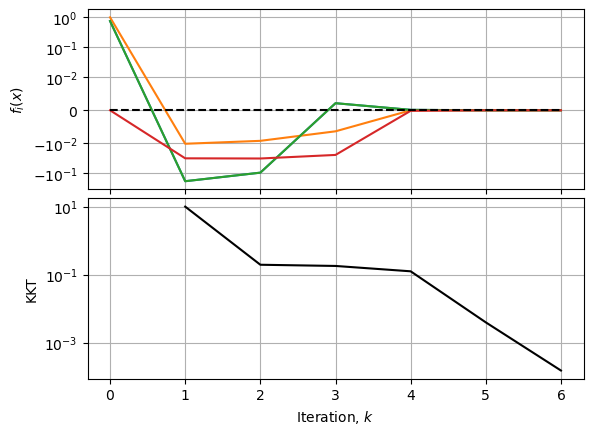

In [7]:
fvals = np.array(fvals)
f0s = np.array(f0s)
kktnorms = np.array(kktnorms)
grad_norms = np.array(grad_norms)
print(kktnorms)

# remove space between the two plots and share the x-axis
fig, ax = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)


# Loop through the four possible fvals: f1, f2, f3, f4
for i in range(0, 4):
    ax[0].plot(fvals[:, i], label=f'$f_{i+1}(x)$')
ax[0].plot(np.zeros_like(fvals[:,0]), 'k--', label='$0$')
# ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('$f_i(x)$')
# Get more log scaling, less linear scaling:
ax[0].set_yscale('symlog', linthresh=1e-2)
# ax[0].legend()
ax[0].grid()

ax[1].plot(kktnorms, 'k-', label='KKT')
ax[1].set_xlabel('Iteration, $k$')
ax[1].set_ylabel('KKT')
ax[1].set_yscale('log')
# ax[1].legend()
ax[1].grid()
# Save the figure as svg
plt.savefig('mma_3bar.svg')

## Try a deep learning problem

In [ ]:
# This function is written by me, and handles the PyTorch / Numpy conversion just like above, but for the GCMMA algorithm. It also includes a very similar "get_loss_and_constraints" function to the one above (which work for the cooper problem wrapper around the PyTorch model).
from gcmma_cooper import gcmma_train

# np and torch seeds
np.random.seed(1)
torch.manual_seed(1)

n_samples = 1000
x = np.linspace(0, 1, n_samples)
y = np.sin(x*np.pi)

train_idx = np.random.choice(n_samples, int(0.8*n_samples), replace=False)
train_idx.sort()
val_idx = np.setdiff1d(np.arange(n_samples), train_idx)
x_train = x[train_idx]
y_train = y[train_idx]
x_val = x[val_idx]
y_val = y[val_idx]

x_t = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
x_v = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1)
y_v = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)


# Define the model
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        layer1 = self.activation(self.fc1(x))
        layer2 = self.fc2(layer1)
        return layer2
    
# Define the problem
class NN_CMP(cooper.ConstrainedMinimizationProblem):
    def __init__(self, lb, ub, model):
        super().__init__(is_constrained = True)
        # These aren't used...
        self.lb = lb
        self.ub = ub

        self.model = model
        # Get the number of parameters and constraints
        self.n = torch.nn.utils.parameters_to_vector(self.model.parameters()).shape[0]
        state = self.closure()
        if state.ineq_defect is not None:
            self.m = state.ineq_defect.shape[0]
        else:
            self.m = 0
    
    def closure(self):
        # Generate prediction:
        y_pred = self.model(x_t)
        # Calculate the loss:
        objective = torch.mean((y_pred - y_t)**2)
        
        # Calculate the constraints:
        # y_pred > -eps, -y_pred < eps
        n_constraints = 5
        # generate 20 random indices on x_t
        # idx = torch.randint(0, x_t.shape[0], (n_constraints,))
        # x_t_sample = x_t[idx]
        # y_pred2 = self.model(x_t_sample)
        # ineq_defect = -y_pred2 - 0.01

        # Basically no constraints:
        for p in self.model.parameters():
            break
        ineq_defect = p[0:2]*0.0 - 1.0


        state = cooper.CMPState(loss=objective, ineq_defect=ineq_defect)
        return state

model = NN()
# model.load_state_dict(torch.load('model.pt'))
problem = NN_CMP(lb=-10, ub=10, model=model)

In [21]:
epochs = 10000
maxinnerit = 20
model.train()
metrics = gcmma_train(problem, epochs, maxinnerit, logger=logger, logger_freq = epochs//10)
parameters = torch.nn.utils.parameters_to_vector(model.parameters())
print(parameters.max())    
print(parameters.min())

2023-04-27 18:37:26,730 - __main__ - INFO - Iter: 0, obj: 5.0438666e-01, max constr: -1.0000e+00, total viol:0.0000e+00
2023-04-27 18:38:03,580 - __main__ - INFO - Iter: 1000, obj: 1.1374176e-03, max constr: -1.0000e+00, total viol:0.0000e+00, kkt: 9.2866e-03, innerit: 4
2023-04-27 18:38:40,553 - __main__ - INFO - Iter: 2000, obj: 8.4201439e-04, max constr: -1.0000e+00, total viol:0.0000e+00, kkt: 1.0184e-02, innerit: 4
2023-04-27 18:39:18,245 - __main__ - INFO - Iter: 3000, obj: 6.4442446e-04, max constr: -1.0000e+00, total viol:0.0000e+00, kkt: 4.8952e-03, innerit: 4
2023-04-27 18:39:57,690 - __main__ - INFO - Iter: 4000, obj: 3.5806617e-04, max constr: -1.0000e+00, total viol:0.0000e+00, kkt: 6.6790e-03, innerit: 4
2023-04-27 18:40:36,412 - __main__ - INFO - Iter: 5000, obj: 1.9880332e-04, max constr: -1.0000e+00, total viol:0.0000e+00, kkt: 4.4108e-03, innerit: 4
2023-04-27 18:41:15,556 - __main__ - INFO - Iter: 6000, obj: 1.5971404e-04, max constr: -1.0000e+00, total viol:0.0000e+

tensor(1.0672, grad_fn=<MaxBackward1>)
tensor(-2.5455, grad_fn=<MinBackward1>)


Max inner iterations: 5.0


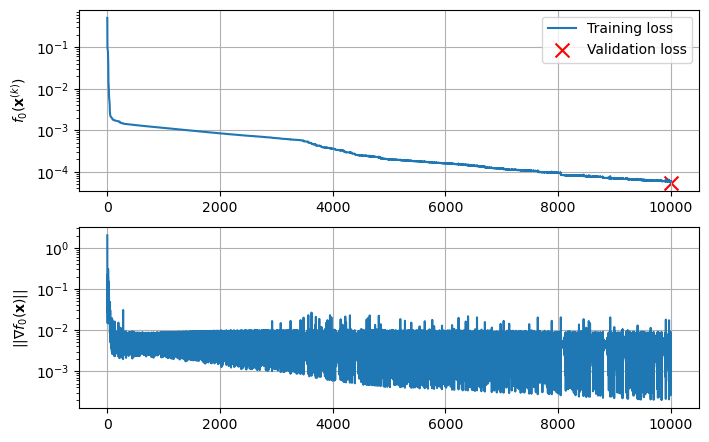

In [26]:
# Get the first half
f_hist = metrics['fvals']
u_losses = metrics['f0s']
grad_norms = metrics['grad_norms']
# metrics[]
# f_losses = np.mean(f_hist**2, axis=1)

model.eval()
with torch.no_grad():
    # Testing error
    y_pred = model(x_v)
    test_loss = torch.mean((y_pred - y_v)**2)

fvals_min = np.min(f_hist, axis=1)
fvals_max = np.max(f_hist, axis=1)
plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.plot(u_losses)
plt.scatter(len(u_losses)-1, test_loss, color='r', marker='x', s=100)
plt.yscale('log')
plt.grid(True)
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.ylabel('$f_0( \mathbf{x}^{{(k)}} )$')

# Constraints: (all satisfied)

# plt.subplot(3,1,2)
# # Plot between min and max as shaded region
# plt.fill_between(range(len(fvals_min)), fvals_min, fvals_max, alpha=0.2)
# # plt.plot(np.median(f_hist, axis=1), color='b')
# plt.yscale('symlog', linthresh=1e-2)
# plt.plot(range(len(fvals_min)), np.zeros_like(fvals_min), 'k--')
# plt.grid(True)
# plt.ylabel('$f_i (\mathbf{x}^{{(k)}} )$')

plt.subplot(3,1,2)
plt.semilogy(grad_norms)
plt.grid(True)
plt.ylabel(r'$||\nabla f_0 (\mathbf{x})||$')
plt.savefig('gcmma_mse_box10.svg')

inner_iterations = metrics['inner_iterations']
inner_iterations = inner_iterations[~np.isnan(inner_iterations)]
print(f'Max inner iterations: {np.max(inner_iterations)}')
# save model
torch.save(model.state_dict(), 'model_10.pt')

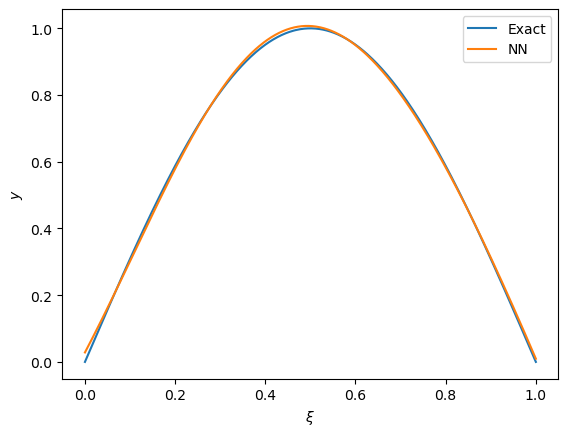

In [29]:
model.eval()
with torch.no_grad():
    # Evaluate the model
    y_pred = model(x_t)
    plt.figure()
    plt.plot(x_t, y_t, label='Exact')
    plt.plot(x_t, y_pred, label='NN')
    plt.legend()
    plt.xlabel(r'$\xi$')
    plt.ylabel('$y$')

### Regular PyTorch Optimizer

tensor(2.9958, grad_fn=<MaxBackward1>)
tensor(-3.5287, grad_fn=<MinBackward1>)


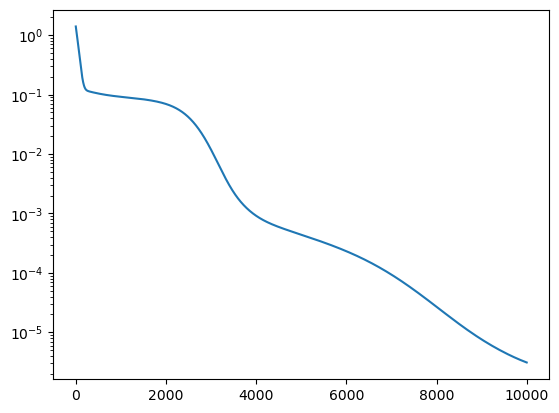

In [61]:
epochs = 10000
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
losses = np.zeros(epochs)
model.train()

for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_t)
    loss = torch.mean((y_pred - y_t)**2)
    loss.backward()
    optimizer.step()
    losses[i] = loss.item()

# Plot losses
plt.figure()
plt.plot(losses)
plt.yscale('log')

parameters = torch.nn.utils.parameters_to_vector(model.parameters())
print(parameters.max())    
print(parameters.min())    
# torch.save(model.state_dict(), 'model.pt')

### Example Application: Adversarial Image Generation

![image](dante.jpg "dante")

In [ ]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

filename = 'dante.jpg'

# From Pytorch documentation for loading models
img = read_image(filename)
img = img[0:3,:,:] / 255.0

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
# Set requires grad to false
for param in model.parameters():
    param.requires_grad = False

model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Get top k predictions
def print_top5(img):
    batch = preprocess(img).unsqueeze(0)
    prediction = model(batch).squeeze(0).softmax(0)
    topk = torch.topk(prediction, k=5)
    class_ids = topk.indices.tolist()
    scores = topk.values.tolist()
    category_names = [weights.meta["categories"][i] for i in class_ids]
    out_str = ""
    for i, (class_id, score, category_name) in enumerate(zip(class_ids, scores, category_names)):
        out_str += (f"{i+1}. {category_name} ({score*100:.2f}%)")
        if i < len(class_ids) - 1:
            out_str += "\n"
    print(out_str)
    return out_str

print_top5(img)
print(img.shape)

1. miniature poodle (30.10%)
2. Irish terrier (9.29%)
3. Tibetan terrier (6.85%)
4. clumber (4.05%)
5. Airedale (2.78%)


'1. miniature poodle (30.10%)\n2. Irish terrier (9.29%)\n3. Tibetan terrier (6.85%)\n4. clumber (4.05%)\n5. Airedale (2.78%)'

In [7]:
class AdversarialImage(torch.nn.Module):
    def __init__(self, img, flatten = False):
        super().__init__()
        self.img = img
        self.flatten = flatten
        if flatten:
            self.noise = torch.nn.Parameter(torch.zeros(img.numel(),1), requires_grad=True)
        else:
            self.noise = torch.nn.Parameter(torch.zeros_like(img), requires_grad=True)

    def forward(self):
        if self.flatten:
            return self.img + self.noise.view(self.img.shape)
        else:
            return self.img + self.noise

batch = preprocess(img).unsqueeze(0)
true_prediction = model(batch).squeeze(0).softmax(0)
adv_img = AdversarialImage(img)
adv_img.train()

optimizer = torch.optim.Adam(adv_img.parameters(), lr=1e-2)
for i in range(100):
    optimizer.zero_grad()
    batch = preprocess(adv_img()).unsqueeze(0)
    prediction = model(batch).squeeze(0).softmax(0)
    loss = -torch.nn.functional.kl_div(prediction, true_prediction, reduction='sum')
    loss.backward()
    optimizer.step()

**Take these results with a grain of salt, as we push the pixel values outside of $[0,1]$, so the inputs to the neural network are not actually images.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1. spider monkey (89.41%)
2. howler monkey (1.79%)
3. siamang (1.65%)
4. chimpanzee (0.90%)
5. gibbon (0.68%)
1. miniature poodle (30.10%)
2. Irish terrier (9.29%)
3. Tibetan terrier (6.85%)
4. clumber (4.05%)
5. Airedale (2.78%)
Adversarial Max / Min
tensor(1.2387, grad_fn=<MaxBackward1>)
tensor(-0.1304, grad_fn=<MinBackward1>)


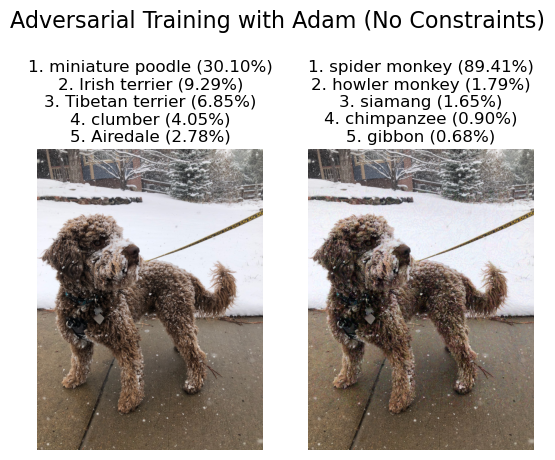

In [8]:
# Use this variable to actually compare an image (what should be done).
# adv_img_clipped = torch.clamp(adv_img(), 0, 1)

out_str_adv = print_top5(adv_img())
out_str = print_top5(img)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0).detach().numpy())
plt.title(out_str)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(adv_img().permute(1,2,0).detach().numpy())
plt.title(out_str_adv)
plt.axis('off')

# Move this title up more
plt.suptitle('Adversarial Training with Adam (No Constraints)', y=1.1, fontsize=16)
plt.savefig('adversarial_training_adam.svg')

print('Adversarial Max / Min')
print(adv_img().max())
print(adv_img().min())

**Redo this, now with GCMMA**

2023-04-27 22:42:06,004 - __main__ - INFO - Evaluated Closure!


1. miniature poodle (24.71%)
2. Irish terrier (10.28%)
3. clumber (3.90%)
4. Airedale (3.43%)
5. Tibetan terrier (3.07%)
Image Max / Min
tensor(0.9000, grad_fn=<MaxBackward1>)
tensor(0.1000, grad_fn=<MinBackward1>)


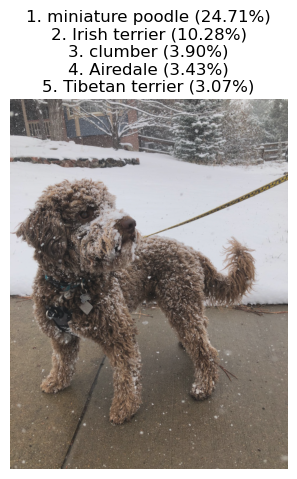

In [11]:
# Subsample the image for debugging
# img_gcmma = img[:,::16,::16]
img_gcmma = img
img_gcmma = 0.8*img_gcmma+0.1*torch.ones_like(img_gcmma)

true_prediction = model(preprocess(img_gcmma).unsqueeze(0)).squeeze(0).softmax(0)

adv_img_gcmma = AdversarialImage(img_gcmma, flatten=True)
adv_img_gcmma.train()

# Create Cooper Class CMP like before for GCMMA
class Adv_CMP(cooper.ConstrainedMinimizationProblem):
    def __init__(self, lb, ub, model):
        super().__init__(is_constrained = True)
        # These aren't used...
        self.lb = lb
        self.ub = ub

        self.model = model
        # Get the number of parameters and constraints
        self.n = self.model.noise.numel()

        state = self.closure()
        if state.ineq_defect is not None:
            self.m = state.ineq_defect.shape[0]
        else:
            self.m = 0
    
    def closure(self):
        # Calculate the loss:
        batch = preprocess(adv_img_gcmma()).unsqueeze(0)
        prediction = model(batch).squeeze(0).softmax(0)
        loss = -torch.nn.functional.kl_div(prediction, true_prediction, reduction='sum')
        
        n_constraints = 5

        # Basically no constraints:
        for p in self.model.parameters():
            break
        ineq_defect = p[0:2]*0.0 - 1.0

        state = cooper.CMPState(loss=loss, ineq_defect=ineq_defect)
        logger.info('Evaluated Closure!')
        return state
    
adv_cmp = Adv_CMP(-0.1, 0.1, adv_img_gcmma)
plt.figure()
plt.axis('off')
plt.title('GCMMA Initialization\n(shifting away from white and black)')
plt.imshow(adv_cmp.model().detach().permute(1,2,0).numpy())
plt.title(print_top5(img_gcmma))

print('Image Max / Min')
print(adv_cmp.model().max())
print(adv_cmp.model().min())

In [15]:
epochs = 5
maxinnerit = 10
metrics = gcmma_train(adv_cmp, epochs, maxinnerit, logger=logger, logger_freq = max(epochs//10,1))

# metrics

2023-04-28 08:42:19,856 - __main__ - INFO - Found Model: AdversarialImage()
2023-04-28 08:42:20,031 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:42:22,358 - __main__ - INFO - Iter: 0, obj: 4.6999621e+00, max constr: -1.0000e+00, total viol:0.0000e+00
2023-04-28 08:43:17,718 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:44:05,951 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:45:04,352 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:46:05,992 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:46:06,180 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:46:09,792 - __main__ - INFO - Iter: 1, obj: 4.6999469e+00, max constr: -1.0000e+00, total viol:0.0000e+00, kkt: 3.0293e-02, innerit: 3
2023-04-28 08:47:14,504 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:48:15,434 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:49:22,187 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:49:22,410 - __main__ - INFO - Evaluated Closure!
2023-04-28 08:49:26,096 -

1. Border terrier (0.44%)
2. lampshade (0.42%)
3. nematode (0.40%)
4. switch (0.35%)
5. lighter (0.35%)
1. miniature poodle (24.71%)
2. Irish terrier (10.28%)
3. clumber (3.90%)
4. Airedale (3.43%)
5. Tibetan terrier (3.07%)
Adversarial Max / Min (GCMMA)
tensor(0.9061, grad_fn=<MaxBackward1>)
tensor(0.0941, grad_fn=<MinBackward1>)


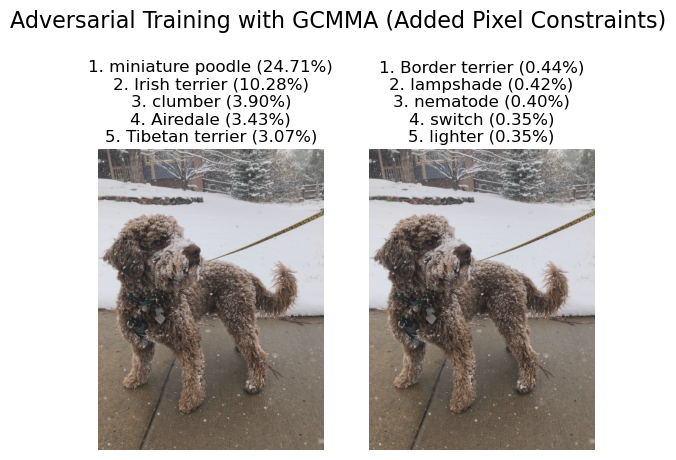

In [16]:
out_str_adv_gcmma = print_top5(adv_img_gcmma())
out_str = print_top5(img_gcmma)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_gcmma.permute(1,2,0).detach().numpy())
plt.title(out_str)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(adv_img_gcmma().permute(1,2,0).detach().numpy())
plt.title(out_str_adv_gcmma)
plt.axis('off')

# Move this title up more
plt.suptitle('Adversarial Training with GCMMA (Added Pixel Constraints)', y=1.1, fontsize=16)
plt.savefig('adversarial_training_adam.svg')

print('Adversarial Max / Min (GCMMA)')
print(adv_img_gcmma().max())
print(adv_img_gcmma().min())